# Cleaning data: removing blur

$NO_2$ data is in principle very useful for estimating traffic. However, $NO_2$ is subject to weather. Wind will carry $NO_2$ over large distances, and rain will wash it out of the atmosphere. To be able to estimate traffic using $NO_2$ data, we will need to account for these distortions. 

In [17]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
import scipy.ndimage as scn
import scipy.signal as scs
import scipy.fftpack as scf
import scipy.stats as st
import skimage.feature as sif
import skimage.restoration as sir
import skimage.segmentation as sis
import shapely as shp
import netCDF4 as nc
import pickle

Looking at the data, it is hard to make out any single pointsources of $NO_2$. Weather has blurred our measurements. 

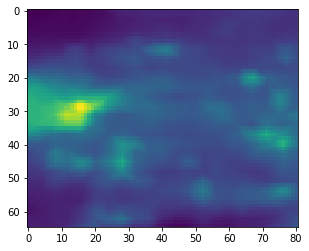

In [18]:
#  'tcno2',
#  <class 'netCDF4._netCDF4.Variable'>
#  int16 tcno2(time, latitude, longitude) <-- stored as int16
#      scale_factor: 4.1492862835272195e-10  <-- automatically applied to stored data
#      add_offset: 1.7391504925921448e-05 <-- automatically allplied to stored data
#      _FillValue: -32767
#      missing_value: -32767
#      units: kg m**-2
#      long_name: Total column Nitrogen dioxide


dataMarch1918 = nc.Dataset("./data/no2_germany_march2019_1800.nc", "r")
dataMarch1900 = nc.Dataset("./data/no2_germany_march2019_0000.nc", "r")
dataApril1918 = nc.Dataset("./data/no2_germany_april2019_1800.nc", "r")
dataApril1900 = nc.Dataset("./data/no2_germany_april2019_0000.nc", "r")
dataFebr1800 = nc.Dataset("./data/no2_germany_february2020_1800.nc", "r")
dataFebr0000 = nc.Dataset("./data/no2_germany_february2020_0000.nc", "r")
dataMarch1800 = nc.Dataset("./data/no2_germany_march2020_1800.nc", "r")
dataMarch0000 = nc.Dataset("./data/no2_germany_march2020_0000.nc", "r")
dataApril1800 = nc.Dataset("./data/no2_germany_april2020_1800.nc", "r")
dataApril0000 = nc.Dataset("./data/no2_germany_april2020_0000.nc", "r")

Tfeb, X, Y = dataFebr1800['tcno2'].shape
Tmarch, _, _ = dataMarch1800['tcno2'].shape
Tapril, _, _ = dataApril1800['tcno2'].shape
Tmeassure = 21
Tdelta = 30

beforeVals1800 = np.concatenate((dataMarch1918['tcno2'][Tmeassure:], dataApril1918['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))
beforeVals0000 = np.concatenate((dataMarch1900['tcno2'][Tmeassure:], dataApril1900['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))
afterVals1800 = np.concatenate((dataMarch1800['tcno2'][Tmeassure:], dataApril1800['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))
afterVals0000 = np.concatenate((dataMarch0000['tcno2'][Tmeassure:], dataApril0000['tcno2'][:(Tdelta - (Tmarch - Tmeassure))]))

beforeVals1800mean = np.mean(beforeVals1800, axis=0)
beforeVals0000mean = np.mean(beforeVals0000, axis=0)
afterVals1800mean = np.mean(afterVals1800, axis=0)
afterVals0000mean = np.mean(afterVals0000, axis=0)


plt.imshow(afterVals1800mean)

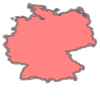

In [19]:
data = gpd.read_file('./data/landkreise_risklayer.geojson')
dateColNames = data.columns[6:-1]
n_obs = data[dateColNames]
nrPlaces, nrTimesteps = n_obs.shape

landkreise = data[data['type'] == 'landkreis']
bundeslaender = data[data['type'] == 'bundesland']
staedte = landkreise[landkreise['population'] >= 100000]
germany = shp.ops.cascaded_union(bundeslaender.geometry)
germany

In [20]:
def round(v):
    return int(v + 0.5)


def coordsToIndex(lon, lat):
    R, C = beforeVals0000mean.shape
    lat0 = 47
    lat1 = 55
    lon0 = 5
    lon1 = 15
    deltaLat = (lat1 - lat0) / R
    deltaLon = (lon1 - lon0) / C
    # lat = lat0 + (R-r) * deltaLat
    r = R - ((lat - lat0) / deltaLat)
    # lon = lon0 + c * deltaLon
    c = (lon - lon0) / deltaLon
    return round(r), round(c)


def indexToCoords(r, c):
    R, C = beforeVals0000mean.shape
    lat0 = 47
    lat1 = 55
    lon0 = 5
    lon1 = 15
    deltaLat = (lat1 - lat0) / R
    deltaLon = (lon1 - lon0) / C
    lat = lat0 + (R-r) * deltaLat
    lon = lon0 + c * deltaLon
    return lon, lat



def matrixInsideShape(data, shape):
    masked = np.zeros(data.shape)
    for r, row in enumerate(data):
        for c, col in enumerate(row):
            lon, lat = indexToCoords(r, c)
            if shape.contains(shp.geometry.Point(lon, lat)):
                masked[r, c] = col
    return masked



In [21]:
def lkCentroidPartition(data, geometries, outline):

    # 1: get centers
    centers = np.zeros(data.shape, dtype=np.int32)
    for i, g in enumerate(geometries):
        ctrd = g.centroid
        lon, lat = ctrd.coords[0]
        r, c = coordsToIndex(lon, lat)
        centers[r, c] = i+1
    
    def findCenter(i):
        if i < 1:
            return None, None
        g = geometries[i-1]
        lon, lat = g.centroid.coords[0]
        return coordsToIndex(lon, lat)

    # 2: watershed
    groups = sis.watershed(-data, centers)
    groups = matrixInsideShape(groups, outline)

    # 3: reassign data
    uniq = np.unique(data)
    minVal = uniq[0] if uniq[0] > 0 else uniq[1]
    newData = np.ones(data.shape) * minVal
    newData = matrixInsideShape(newData, outline)
    for r, row in enumerate(data):
        for c, val in enumerate(row):
            i = int(groups[r, c])
            rc, cc = findCenter(i)
            if rc and cc:
                newData[rc, cc] += val - minVal

    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(data)
    axes[0].imshow(centers, alpha=0.4)
    axes[0].set_title('data with centers')
    axes[1].imshow(groups)
    axes[1].imshow(centers, alpha=0.4)
    axes[1].set_title('watersheds')
    axes[2].imshow(newData)
    axes[2].set_title('repartitioned data')

    return newData

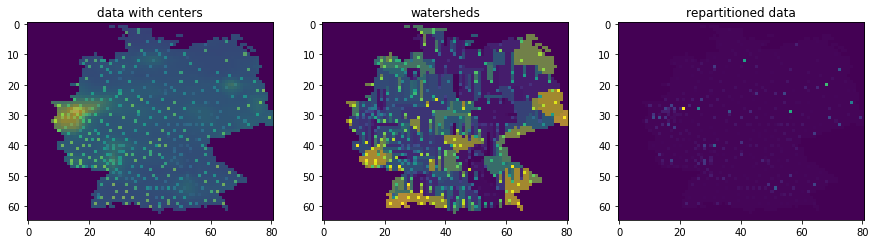

In [22]:
data = matrixInsideShape(afterVals1800mean, germany)
repartitioned = lkCentroidPartition(data, landkreise.geometry.values, germany)

In [23]:
np.sum(data) - np.sum(repartitioned)

0.0

In [24]:
def peakPartition(data, outline, minDistance=1):

    # 1: get maxima
    maxCoords = sif.peak_local_max(data, min_distance=minDistance)
    iMaxCoords = [(i+1, coords[0], coords[1]) for i, coords in enumerate(maxCoords)]
    maxMatr = np.zeros(data.shape)
    for i, r, c in iMaxCoords:
        maxMatr[r, c] = i
    
    def findCenter(i0):
        for i, r, c in iMaxCoords:
            if i == i0:
                return r, c
        return False, False
    
    # 2: watershed
    groups = sis.watershed(-data, maxMatr)
    groups = matrixInsideShape(groups, outline)

    # 3: reassign data
    uniq = np.unique(data)
    minVal = uniq[0] if uniq[0] > 0 else uniq[1]
    newData = np.ones(data.shape) * minVal
    newData = matrixInsideShape(newData, outline)
    for r, row in enumerate(data):
        for c, val in enumerate(row):
            i = groups[r, c]
            rc, cc = findCenter(i)
            if rc and cc:
                newData[rc, cc] += val - minVal
    

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(data)
    axes[0].imshow(maxMatr, alpha=0.4)
    axes[0].set_title('data with peaks')
    axes[1].imshow(groups)
    axes[1].imshow(maxMatr, alpha=0.4)
    axes[1].set_title('watersheds')
    axes[2].imshow(newData)
    axes[2].set_title('repartitioned data')

    return newData

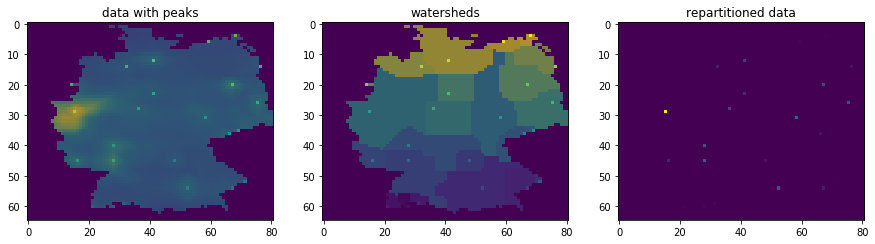

In [25]:
data = matrixInsideShape(afterVals1800mean, germany)
repartitioned = peakPartition(data, germany, 2)

In [26]:
repartitioned[40, 40]

4.020183337008135e-06

In [27]:
np.sum(data) - np.sum(repartitioned)

-3.469446951953614e-18

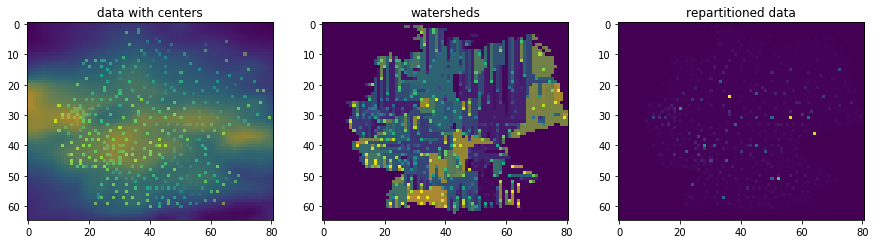

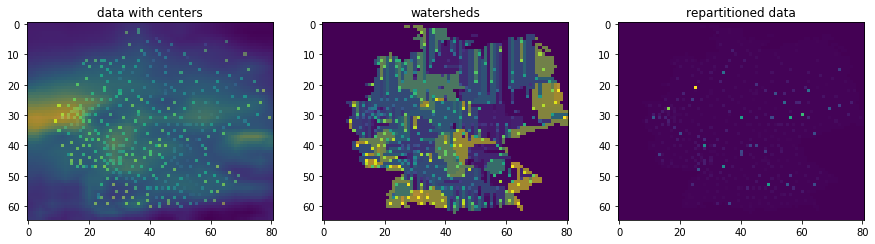

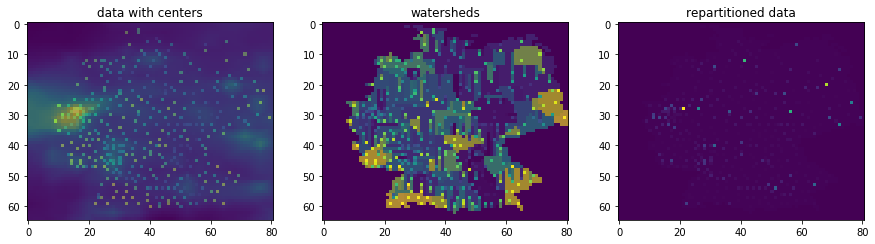

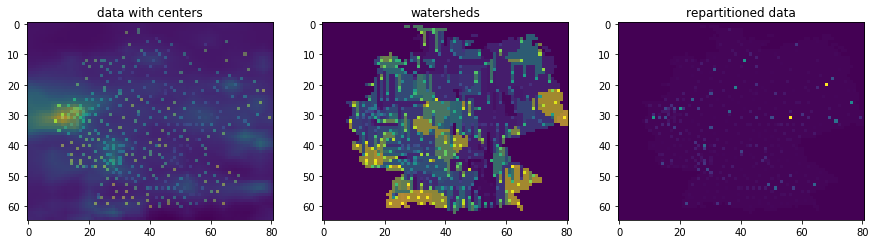

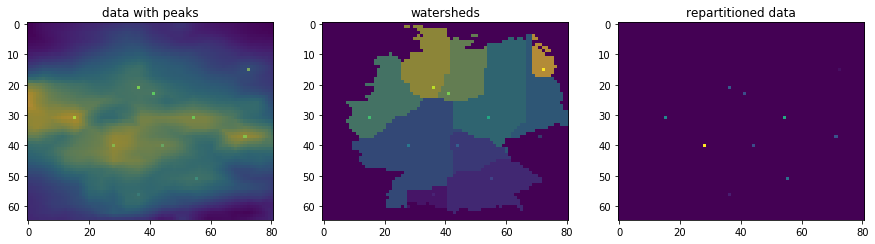

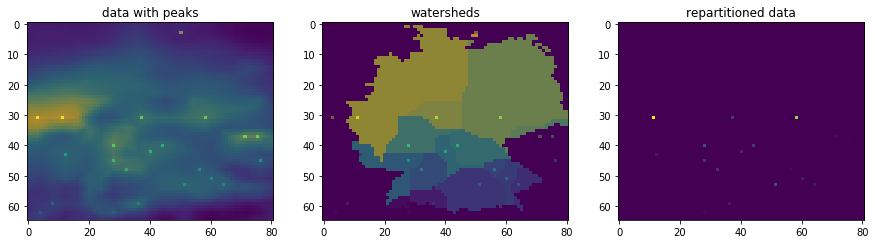

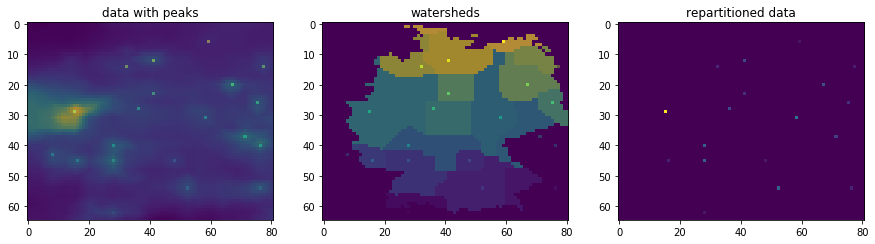

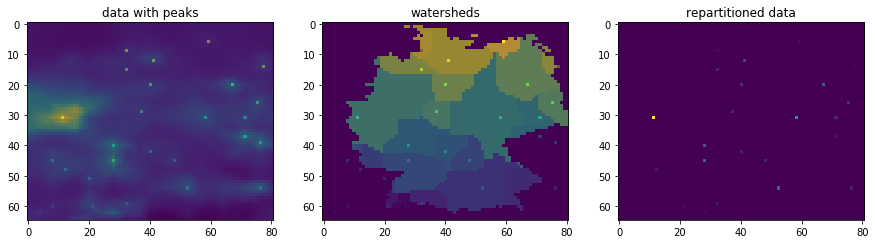

In [29]:
datasets = {
    "lastyear_1800": beforeVals1800mean, 
    "lastyear_0000": beforeVals0000mean, 
    "after_1800": afterVals1800mean, 
    "after_0000": afterVals0000mean
}
geometries = landkreise.geometry.values
for name, dataset in datasets.items():
    repartitionedA = lkCentroidPartition(dataset, geometries, germany)
    np.save(f'./data/centered/repartitioned_cntr_{name}', repartitionedA)
for name, dataset in datasets.items():
    repartitionedB = peakPartition(dataset, germany, 2)
    np.save(f'./data/centered/repartitioned_peak_{name}', repartitionedB)